# Use of neural networks for inversion of seismic data

Gunter Roethe and Albert Tarantola (1991) Use of neural networks for inversion of seismic data. SEG Technical Program Expanded Abstracts 1991: pp. 302-305.
https://doi.org/10.1190/1.1888938 

Reproduced by: Brendon Hall, [Enthought](www.enthought.com)

This notebook reproduces the analysis presented by R\uuml;th and Tarantola (1991).  The use neural networks for two geophysical inversion problems.  The first network predicts the depth and velocity of a single reflector based on a series of offset traveltime observations.  The second network predicts a 3 layer 1D velocity model based on a single seismogram.

In [554]:
%matplotlib inline
import numpy as np
import pylab as plt
import bruges

from fatiando.seismic import conv
from fatiando.vis import mpl

from sklearn.neural_network import MLPRegressor

np.random.seed(42)

### Roethe and Tarantola (1991) Figure 2
<img src="../images/RT91_Fig2.png" alt="drawing" width="500"/>

Generate the input values (traveltime observations) for the first model.  The data consists of travel times from an ensemble of 200 simple earth models.  These models are parameterized by one flat reflector at depth d=0.1 - 0.4 km, with a velocity of 2.3-3.8 km/s.

Travel time are computed for an array of 24 receivers located at increasing offset from a source.

In [653]:
# function to compute travel time given depth, offset and velocity
def get_travel_time(depth, offset, velocity):
    dist = 2*np.sqrt(np.power(offset/2, 2) + np.power(depth, 2))
    return dist/velocity

The paper isn't clear about the exact geometry of the receiver locations.  Figure 3 suggests travel times around 1s for the furthest receiver. Given a mean depth of 0.25 km and a mean velocity of 3.05 km/s, what offset gives a travel time around 1s? 

In [654]:
dist = 3
time = get_travel_time(0.25, dist, 3.05)
print('Travel time to receiver at %d km is %.2f s'%(dist, time))

Travel time to receiver at 3 km is 1.00 s


Set up the receiver geometry, based on the distance to the furthest reciever and 24 receivers in total.

In [655]:
num_receivers = 24
initial_receiver_offset = .025 # m
final_receiver_dist = 3 # km

receiver_offsets = np.linspace(initial_receiver_offset,
                             final_receiver_dist, 
                             num_receivers)

In [656]:
num_models = 200

depths = []
vels = []
model_times = []

r = np.random.RandomState(1234)

for i in np.arange(num_models):
    # 2.3 to 3.8 km/s
    vel = (2.3 + 1.5 * r.rand()) 
    # 0.1 to 0.4 km
    depth = 0.1 + 0.3 * r.rand()
    depths.append(depth)
    vels.append(vel)
    
    times = get_travel_time(depth, receiver_offsets, vel)
    model_times.append(times)

Turn the model times into a input feature matrix, $X$, and the corresponding model depths and velocities into a target matrix, $y$.

In [657]:
y = np.stack([depths, vels], axis=1)
y[:,1] /= 3.8 # normalize velocity values
X = np.array(model_times)

In [658]:
X.shape

(200, 24)

In [659]:
y.shape

(200, 2)

### Roethe and Tarantola (1991) Figure 3



<img src="../images/RT91_Fig3.png" alt="drawing" width="500"/>

(0, 1.2)

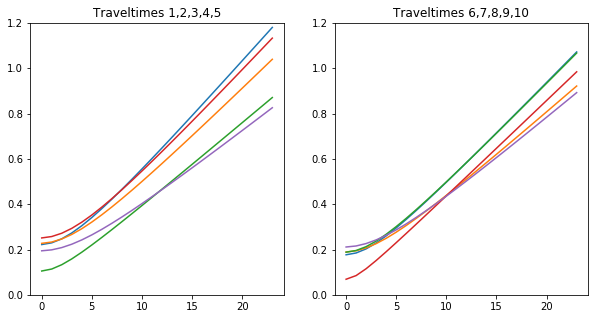

In [660]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(X[:5,:].T)
ax[0].set_title('Traveltimes 1,2,3,4,5')
ax[0].set_ylim([0, 1.2])

ax[1].plot(X[5:10,:].T)
ax[1].set_title('Traveltimes 6,7,8,9,10')
ax[1].set_ylim([0, 1.2])

## Training the network

In the paper, R&ouml;th and Tarantola note
> In a first run we trained our network to "learn" all 200 examples. After a few hours on a Convex Cl, the algorithm convergedto a misfit valueof $1.19\times10^{-2}$.

The mistfit is defined as
$M(W) = \sum_{i} \left( vel_{pred}^i - vel_{true}^i \right)^2 + \left( d_{pred}^i - d_{true}^i \right)^2$

In [661]:
# define function to compute misfit of results
def compute_misfit(y_pred, y_true):
    return np.sum(np.power(y_pred-y_true, 2))/y_true.shape[0]

Loss from RT91 method: 9.80e-04
Loss from solver: 4.09e-04


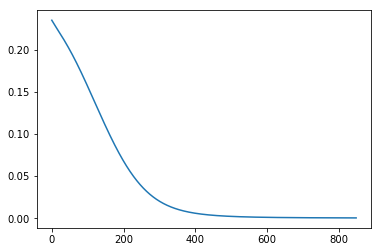

In [663]:
nn1 = MLPRegressor(hidden_layer_sizes=(10, ), max_iter=10000, tol=1e-6)
nn1.fit(X,y)
y_pred = nn1.predict(X)

print('Loss from RT91 method: %.2e'%(compute_misfit(y_pred, y)))

plt.plot(nn.loss_curve_)
print('Loss from solver: %.2e'%nn.best_loss_)

### Roethe and Tarantola (1991) Figure 4


<img src="../images/RT91_Fig4.png" alt="drawing" width="500"/>

(0, 0.6)

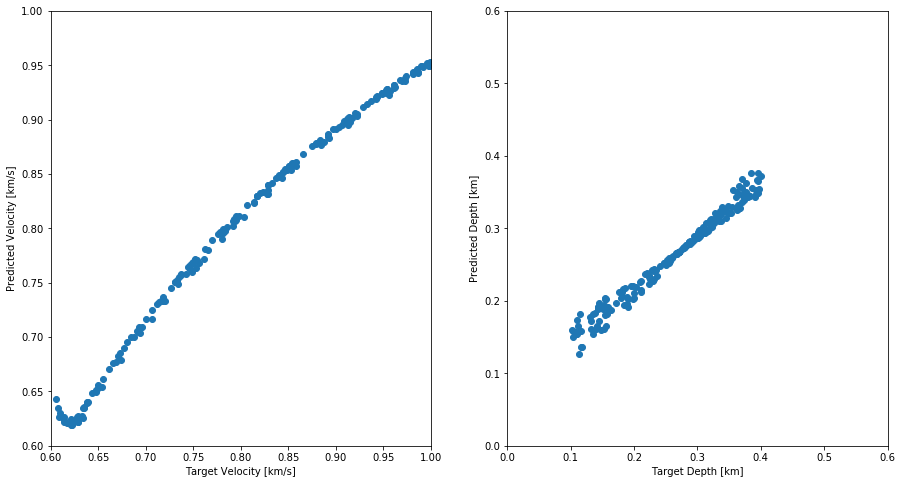

In [664]:
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].scatter(y[:,1], y_pred[:,1])
ax[0].set_xlabel('Target Velocity [km/s]')
ax[0].set_ylabel('Predicted Velocity [km/s]')
ax[0].set_ylim([0.6, 1.0])
ax[0].set_xlim([0.6, 1.0])

ax[1].scatter(y[:,0], y_pred[:,0])
ax[1].set_xlabel('Target Depth [km]')
ax[1].set_ylabel('Predicted Depth [km]')
ax[1].set_ylim([0, 0.6])
ax[1].set_xlim([0, 0.6])

### Roethe and Tarantola (1991) Figure 5


<img src="../images/RT91_Fig5.png" alt="drawing" width="500"/>

(0, 0.6)

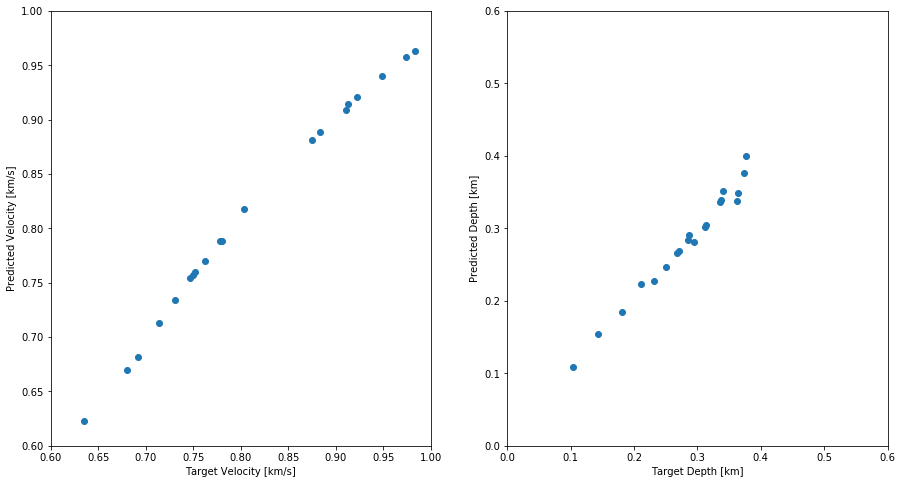

In [667]:
X_sm = X[:20, :]
y_sm = y[:20, :]

nn2 = MLPRegressor(hidden_layer_sizes=(10, ), max_iter=10000, tol=1e-6)
nn2.fit(X_sm,y_sm)
y_sm_pred = nn2.predict(X_sm)

fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].scatter(y_sm[:,1], y_sm_pred[:,1])
ax[0].set_xlabel('Target Velocity [km/s]')
ax[0].set_ylabel('Predicted Velocity [km/s]')
ax[0].set_ylim([0.6, 1.0])
ax[0].set_xlim([0.6, 1.0])

ax[1].scatter(y_sm[:,0], y_sm_pred[:,0])
ax[1].set_xlabel('Target Depth [km]')
ax[1].set_ylabel('Predicted Depth [km]')
ax[1].set_ylim([0, 0.6])
ax[1].set_xlim([0, 0.6])

### Roethe and Tarantola (1991) Figure 6


<img src="../images/RT91_Fig6.png" alt="drawing" width="500"/>

(0, 0.6)

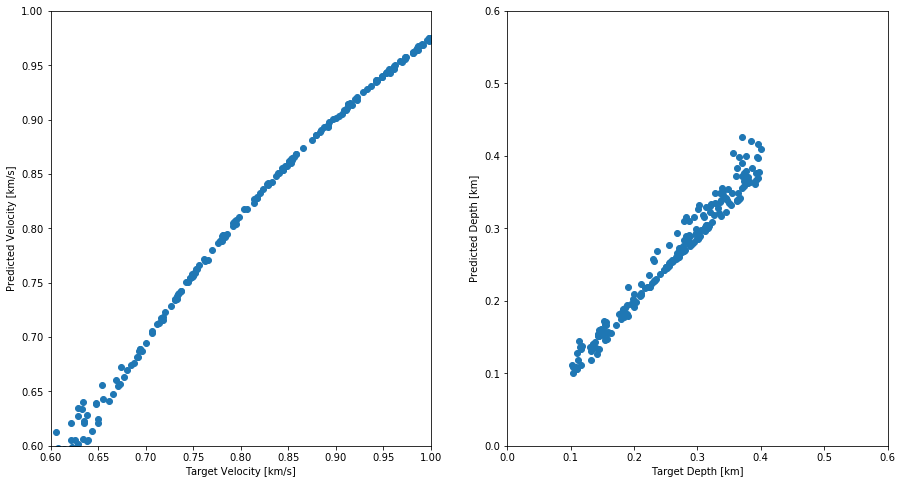

In [668]:
y_aug_pred = nn2.predict(X)

fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].scatter(y[:,1], y_aug_pred[:,1])
ax[0].set_xlabel('Target Velocity [km/s]')
ax[0].set_ylabel('Predicted Velocity [km/s]')
ax[0].set_ylim([0.6, 1.0])
ax[0].set_xlim([0.6, 1.0])

ax[1].scatter(y[:,0], y_aug_pred[:,0])
ax[1].set_xlabel('Target Depth [km]')
ax[1].set_ylabel('Predicted Depth [km]')
ax[1].set_ylim([0, 0.6])
ax[1].set_xlim([0, 0.6])

Now let's look at the second network.  For this problem, R\ouml;th generated an ensemble of 3-layer 1D constant velocity earth models.  They originally generated 14 of these models, so let's start with that.

The models...[description]

In [630]:
models = []
vps = []
rcs = []
synths = []

num_models = 14
num_layers = 3
num_depth = 60
layer_points = int(num_depth / num_layers)
layer_thickness = 200 # meters
dz = layer_thickness/layer_points
depths = np.linspace(0, 600, 60)

for i in np.arange(num_models):
    model = np.zeros(num_layers)
    vp = np.zeros((num_depth,1))
    vs = np.ones((num_depth,1))
    rho = np.ones((num_depth,1))
    # first layer velocity
    perturb = np.random.randint(-100, 100)
    layer_vp = 1200 + perturb
    model[0] = layer_vp
    vp[:layer_points] = layer_vp
    
    

    
    for l in np.arange(1,num_layers):
        perturb = np.random.randint(-100, 100)
        layer_vp = (model[l-1] + 450) + perturb
        model[l] = layer_vp
        start_ind = int(l * layer_points)
        end_ind = int((l+1) * layer_points)
        #print('start: {}, end: {}'.format(start_ind, end_ind))
        vp[start_ind:end_ind] = layer_vp        
        
    
    rcb = bruges.reflection.reflectivity(vp, vs, rho, theta=[0])
    vel_l = conv.depth_2_time(vp, vp, dt=6e-3, dz=dz)
    rho_l = 2200*np.ones(np.shape(vel_l))
    rc = conv.reflectivity(vel_l, rho_l)
    synt = conv.convolutional_model(rc, 30, conv.rickerwave, dt=2e-3)
    
    models.append(model)
    vps.append(vp)
    rcs.append(rcb)
    synths.append(synt)

/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/seismic/conv.py:139: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  TWT_rs = np.zeros(np.ceil(TMAX/dt_dwn))
/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/seismic/conv.py:164: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  vel[kk:lim, j] = tck(TWT_rs[kk:lim])
/Users/bhall/.edm/envs/deeplearning/lib/python3.6/site-packages/fatiando/seismic/conv.py:166: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  vel[lim:, j] = vel[lim-1, j]
/Users/bhall/.edm/envs/dee

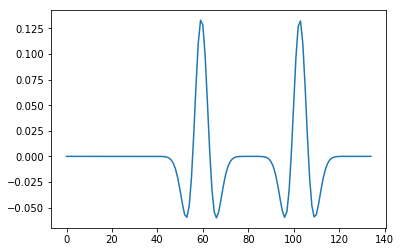

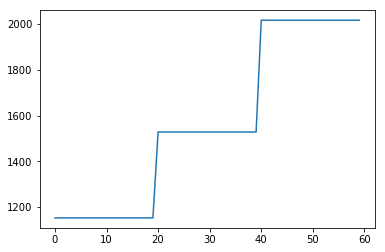

In [631]:
plt.plot(synt)
plt.figure()
plt.plot(vp)

The output of the NN are layer velocities.  So the model is the output.  The input are the synthetic seismograms associated with them.

In [632]:
y = np.array(vps)[:,:,0] # normalize model velocities
max_vel = np.max(y)
y /= max_vel
max_vel

2349.0

In [633]:
# pad each seismogram with zeros so they are the same length
max_size = int(np.max([el.shape[0] for el in synths]))
cleaned_synths = []
for s in synths:
    pad_width = max_size - int(s.shape[0])
    s = np.pad(s, pad_width=((0,pad_width),(0,0)), mode='constant', constant_values=[0])
    cleaned_synths.append(s)

In [634]:
X = np.array(cleaned_synths)[:,:,0]

In [635]:
X.shape

(100, 142)

In [637]:
nn = MLPRegressor(hidden_layer_sizes=(5, ), max_iter=10000, tol=1e-6)
nn.fit(X,y)
y_pred = nn.predict(X)

### Roethe and Tarantola (1991) Figure 7
<img src="../images/RT91_Fig7.png" alt="drawing" width="500"/>

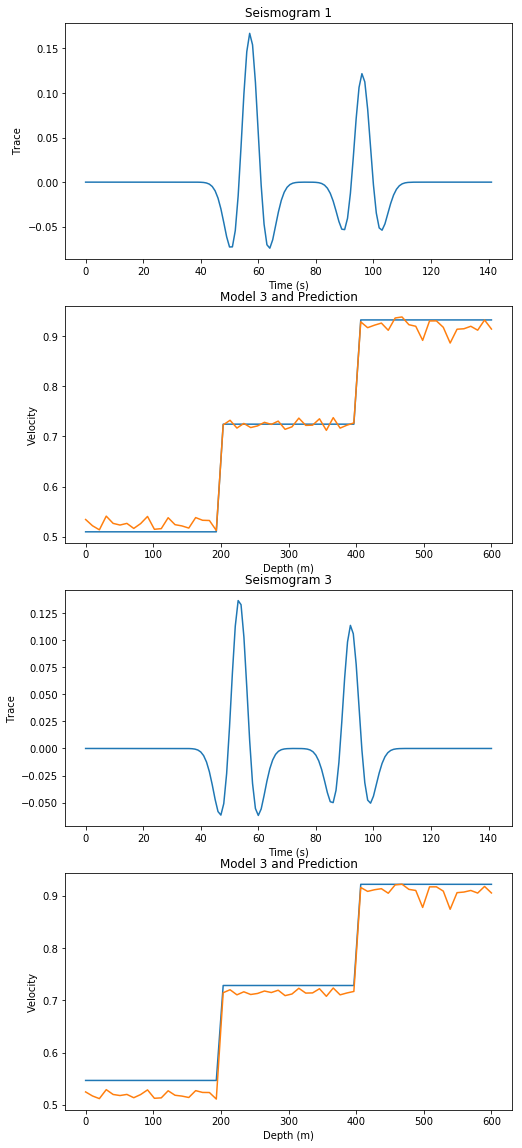

In [638]:
fig, ax = plt.subplots(4,1, figsize=(8,20))

ax[0].plot(cleaned_synths[0])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Trace')
ax[0].set_title('Seismogram 1')

ax[1].plot(depths, y[0])
ax[1].plot(depths, y_pred[0])
ax[1].set_xlabel('Depth (m)')
ax[1].set_ylabel('Velocity')
ax[1].set_title('Model 3 and Prediction')

ax[2].set_title('Seismogram 3')
ax[2].plot(cleaned_synths[3])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Trace')

ax[3].set_title('Model 3 and Prediction')
ax[3].plot(depths, y[3])
ax[3].plot(depths, y_pred[3])
ax[3].set_xlabel('Depth (m)')
ax[3].set_ylabel('Velocity')

### Roethe and Tarantola (1991) Figure 8


<img src="../images/RT91_Fig8.png" alt="drawing" width="500"/>

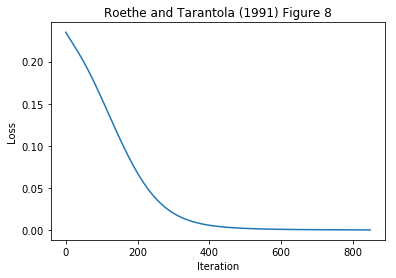

In [669]:
from sklearn.model_selection import learning_curve
loss_values = nn.loss_curve_
plt.plot(loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Roethe and Tarantola (1991) Figure 8')

### Roethe and Tarantola (1991) Figure 9


<img src="../images/RT91_Fig9.png" alt="drawing" width="500"/>

In [ ]:
# TODO